## Homework 2 - Model Selection and Regularization
In this homework, we will explore the need for regularization and cross validation. Your goal is to determine
the *true* model that exists in this superfluous data set. 

Just a quick reminder on how to submit homework solutions:
    
``` $ git add myhomeworksolutions.ipynb ```

``` $ git commit -m "added my homework 1 solutions" ```

``` $ git push origin master $ ```

Run the cell below to load the libraries

In [92]:
import numpy as np
import pandas as pd
from scipy.stats import binom
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
from sklearn.neighbors import KNeighborsRegressor
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso

## Problem 1: Not So Nearest Neighbors

In this problem we look into the **curse of dimensionality**  (https://en.wikipedia.org/wiki/Curse_of_dimensionality).

Recall from lecture that when solving the ordinary least squares, the solution to 

$$\min_f \mathbb{E}_{y \lvert x} (y - f(x))^2,$$

is $$ f(x) = \mathbb{E}(y \lvert x).$$


As usual though, we only have access to the sampled data $(\mathbf{x}_i, y_i)$. Thus we seek to find (as seen in lecture)

$$ \hat f(x) :=  \hat{\mathbb{E}}(y \lvert x).$$

The simple approach which is the most natural way to estimate $f$ is to average $y_i$ over over observations $x_i$ such that $x_i=x$

$$ \hat{\mathbb{E}}(y \lvert x) = \frac{1}{N_{x_i=x}} \sum_{x_i, x_i=x} y_i,$$

where $N_{x_i=x}$ is the number of points such that $x_i=x$. **But we cannot do this since we only have access to the training data, not all $x$, and we generally have at most one instance of each $x_i$**. Thus we settle for

$$ \hat{\mathbb{E}}(y \lvert x) := \frac{1}{k} \sum_{x_i \in N_k(x)} y_i,$$

where $N_k(x)$ denotes the set of the $k$ closest points to $x$. 

### Goal of this problem:
To understand how the set $N_k(x)$ behaves as we increase the dimension. The intuition is that it's much harder to find points close to $x$ as we increase the *degrees of freedom* of our samples. We will see that this means we have to search larger distances to find these points, and these points may not reflect the value of $y_i$ well at all!

**[15 points]** a) Run the code below to create a sample from a $p$ dimensional uniform distribution, denoted $\mathcal{U}(-1,1)^p$.  



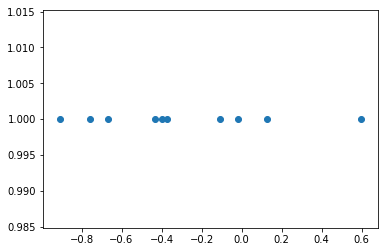

In [93]:
p=1
X=np.zeros(shape=(10,p))
for k in range(X.shape[1]):
    X[:,k] = np.random.uniform(-1,1,10)
plt.scatter(X[:,k] ,[1]*10)

What is the distance of $x=0$ to its nearest neighbor? You can use `np.min` and `np.abs` here. 

In [94]:
np.min(np.abs(X))

0.0164013324807335

Repeat the above but now for $p=2$ and make a scatter plot on $[-1,1] \times [-1,1]$. Use `X=np.zeros(shape=(10,p))` to initialize the matrix, and make sure that each row is a point sampled from a 2d uniform distribution (you can do this by setting each column to be sampled from a 1d uniform distribution). 

Distance of x = 0 to its nearest neighbor:  0.015764237086450358


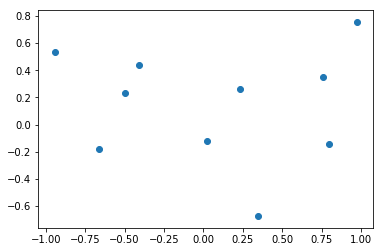

In [122]:
p=2
X=np.zeros(shape=(10,p))
for k in range(X.shape[1]):
    X[:,k] = np.random.uniform(-1,1,10)
plt.scatter(X[:,0] ,X[:,1])

print("Distance of x = 0 to its nearest neighbor: ", np.min((X**2).sum(axis=1)))

Finally, repeat the problem for various values of $p$, ($p=10,20,100$, etc. ). What do you notice about the distances? Can you explain why this may be happening?

In [123]:
for p in [10,20,100]:
    X=np.zeros(shape=(10,p))
    for k in range(X.shape[1]):
        X[:,k] = np.random.uniform(-1,1,10)
    print("when p = {} case, distance of  x=0  to its nearest neighbor: ".format(p), round(np.min((X**2).sum(axis=1)),3))

when p = 10 case, distance of  x=0  to its nearest neighbor:  1.446
when p = 20 case, distance of  x=0  to its nearest neighbor:  4.477
when p = 100 case, distance of  x=0  to its nearest neighbor:  29.637


**[Solution]:** When the dimension of feature space is increasing, the closet point is still far way from origin, so getting harder to find the nearest neighbor.

**[10 points]** b)  Let's do something more precise to find out what's happening. Assume that there are $N$ points which are uniformly distributed in a sphere in $\mathbb{R}^n$. Find the probabiltity that the nearest neighbor of the origin is at a distance larger than or equal to $r$ and show that it is

$$  P(y \geq R) = \left (1- r^p\right)^N.$$

You can assume the volume of the sphere in $\mathbb{R}^p$ is $C_pr^p$. 

**Hint:** First find the probability that given one point, that it is not within a ball of radius $r$ centered around the origin. Then use independence to find the case when there are $N$ points. 

**[Solution]:**
Define random variables independent of each other and uniformly distributed:

$$y_i,...,y_n \sim Unif[0,1]$$

Given one point, the probability is within a ball of radius $r$:

$$p(y_i < R) = \frac{C_pr^p}{C_p1^p} \implies p(y_i < R) = 1 - r^p \implies p(y_1,...y_n \geq R) = (1 - r^p)^N$$


**[5 points]** c) Given your solution to part b), what is the median of the above distribution? 

From part b):
    
$$p(y_1,...y_n \geq R) = (1 - r^p)^N \implies p(y_1,...y_n < R) = 1-(1 - r^p)^N$$

Set this cdf to 0.5, because we are looking for the meridian

$$1-(1 - r^p)^N = 0.5 \implies r_{0.5} = (1 - 0.5^{1/N})^{1/p}$$

**[5 points]** d)  Make a plot of $(p, P(y \geq 1/2))$ for  $N=50$. What happens as $p \to +\infty$ for fixed $N$? (ie. the number of poitns is fixed, but the dimension tends to $+\infty$). What does this tell you? In other words, where are all of the points accumulating?

Text(0,0.5,'Probability')

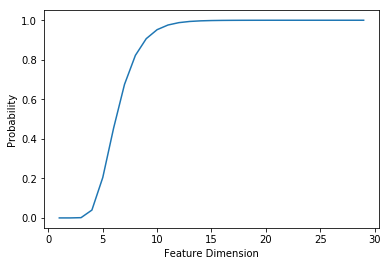

In [97]:
N = 50
r = 1/2
p = np.arange(1,30, 1)
prob = (1 - r**p)**N
plt.plot(p, prob)
plt.xlabel('Feature Dimension')
plt.ylabel("Probability")

**[Solution]:** When the dimension of feature $p$ is increasing, the distance between the nearest neighbor to origin is larger, so the probability distance $d(p, N)$ is greater than the 0.5 is approaching to 1

**[2 points]** e) Run the code in the cell below. The second cell computes the nearest neighbors regressor for this data. 

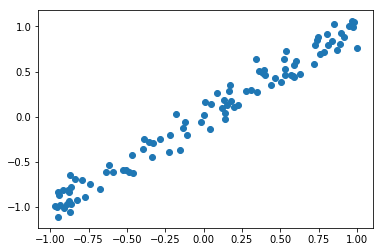

In [98]:
%matplotlib inline
X = np.random.uniform(-1,1,100)
epsilon = np.random.normal(0,0.1,100)
y = X + epsilon
plt.scatter(X,y)

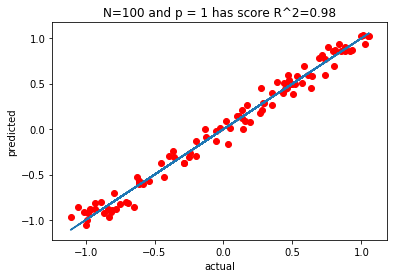

In [99]:
p = 1
T = np.linspace(-1,1,1000)
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X.reshape(-1,1), y) 

y_hat = neigh.predict(X.reshape(-1,1))
r2 = round(neigh.score(X.reshape(-1,1),y),2)

plt.xlabel("actual")
plt.ylabel("predicted")
plt.title("N=100 and p = {0} has score R^2={1}".format(p,r2))
plt.plot(y,y)
plt.scatter(y,y_hat, color = 'r')

**[10 points]** e) Repeat the above but for larger dimensions $p=10, 50, 100, 500$ so that the $N$ points are sampled from $\textrm{Unif}[-1,1]^p$ What happens to the scatter plot of predictions vs true values as the dimension increases? What happens to the $R^2$? Can you explain this in terms of your conclusions from the previous parts a) - c)?

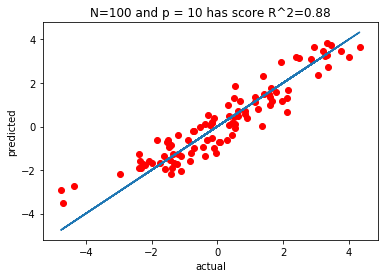

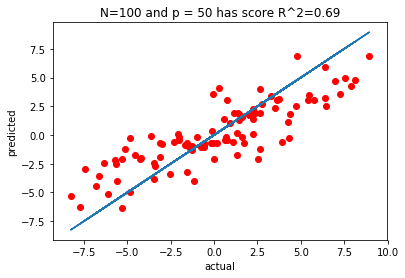

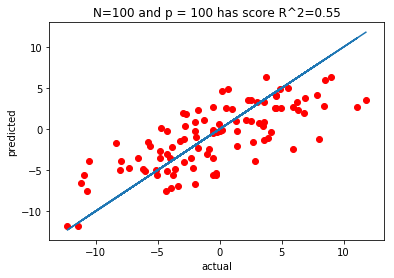

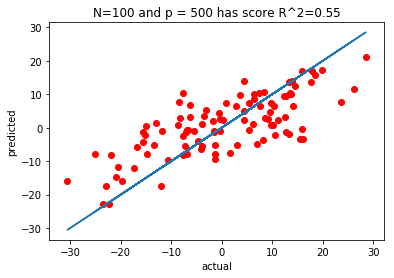

In [100]:
for p in [10, 50, 100, 500]:
    X=np.zeros(shape=(100,p))
    for k in range(X.shape[1]):
        X[:,k] = np.random.uniform(-1,1,100)
    
    epsilon = np.random.normal(0,0.1,100)
    
    y = X.sum(axis=1) + epsilon
    neigh = KNeighborsRegressor(n_neighbors=2)
    neigh.fit(X, y)

    y_hat = neigh.predict(X)
    r2 = round(neigh.score(X,y),2)

    plt.figure()
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.title("N=100 and p = {0} has score R^2={1}".format(p,r2))
    plt.plot(y,y)
    plt.scatter(y,y_hat,color='r')

**[Solution]:** Based on the plots above, when the dimension of feature space $p$ is increasing, the distances between two points become larger and larger. Therefore, if use KNN regressor to predict data based on the closest points, it's likely to lost information and get bias predictions, which $R^2$ is lower when $p = 500$ 

## Problem 2: Manual Model Selection

In this exercise, we have data which is sampled from a distribution which takes the form:
 $$y = \beta^T \cdot x + \epsilon.$$
 
 We are not told in advance what $\beta$ is though. That's up to you to discover. 

**[5 points]** a) Load the data `hw3.csv` into a Pandas dataframe located in `data/` in the course repository. Set $X$ to be the variables $0, \cdots, 50$ and $y$ to be the $y$ variable. 

In [101]:
data = pd.read_csv('./hw3.csv')
x = data.iloc[:,range(50)]
y = data.iloc[:, 50]

**[5 points]** b) Compute the covariance matrix of $X$ (ie. $X^TX$). What does this tell you about the features?

In [102]:
pd.DataFrame(np.cov((x.T).dot(x))).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.020000,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,...,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408
1,-0.000408,0.020000,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,...,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408
2,-0.000408,-0.000408,0.020000,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,...,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408
3,-0.000408,-0.000408,-0.000408,0.020000,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,...,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408
4,-0.000408,-0.000408,-0.000408,-0.000408,0.020000,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,...,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408,-0.000408


**[Solution]:** Each feature has same variance 0.02, and correlation between two features is very close to 0. Therefore, I can claim that each feature is orthogonal, so they are all independent features. 

**[10 points]** c) Starting $k$ from 1 and ranging to 50 (the total number of features), build a linear regression model  for $X[:,0:k]$ (where this denotes the matrix restricted to the first k columns), and plot the predictions against the actual values.  What happens as the number of features included increases? Why is this not surprising given what you know about linear alegbra and part b)? Recalling Homework 0 Problem 2 may be helpful. 

The following code will be useful:

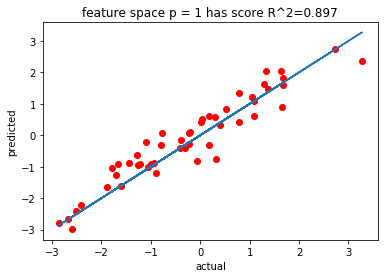

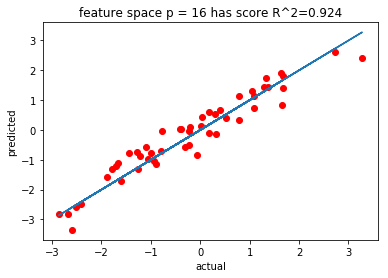

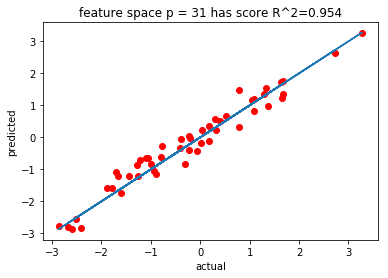

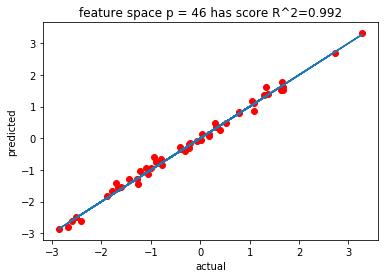

In [103]:
for d in range(0,50,15):
    # add one feature in feature space each time
    X=x.loc[:,'0':str(d)]
    
    # fit a linear regression
    model = linear_model.LinearRegression(fit_intercept=False)
    model.fit(X, y)
    
    # calcuate fit value
    y_hat = model.predict(X)
    r2 = r2_score(y, y_hat)
    
    # plot the predictions against the actual values
    plt.figure()
    plt.scatter(y,y_hat,color='r')
    plt.plot(y,y)
    plt.title("feature space p = {0} has score R^2={1}".format(d+1,round(r2,3)))
    plt.xlabel("actual")
    plt.ylabel("predicted")

**[Solution]** When the dimension of feature space $P$ is increasing ($P \to N$), train the linear regression depended on more and more features, and eventually the coefficient will be calculated by single data point. Therefore, the model is fitting data more precise and lower bias, which indicate by lower $R^2$

**[10 points]** d) Split the data randomly into 80% training and 20% testing using `test_train_split` in Python. Repeat part c) on the training data, and
plot the $R^2$ of the model on the training and testing data against the number of features used. What happens to the training and testing error as you do this?

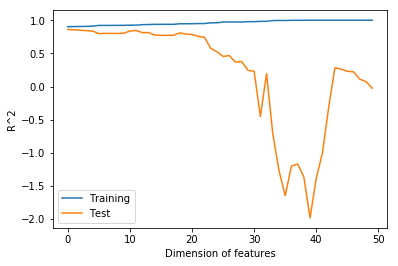

In [104]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1234)

R2_train = np.array([])
R2_test = np.array([])

for d in range(0,50):
    # add one feature in feature space each time
    X_train = x_train.loc[:,'0':str(d)]
    X_test = x_test.loc[:,'0':str(d)]
    
    # fit a linear regression
    model = linear_model.LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    
    # calcuate fit value
    y_hat = model.predict(X_train)
    y_pred = model.predict(X_test)
    R2_train = np.append(R2_train, r2_score(y_train, y_hat))
    R2_test = np.append(R2_test, r2_score(y_test, y_pred))
    
# plot the predictions against the actual values
plt.plot(list(range(0,50)), R2_train, label = "Training")
plt.plot(list(range(0,50)), R2_test, label = "Test")
plt.xlabel("Dimension of features")
plt.ylabel("R^2")
plt.legend()

**[Solution]:** When the dimension of feature space $P$ is increasing ($P \to N$), the training error is descreasing, but the test error is increasing dramatically. Therefore, I can conclude that training regression models with large feature space will easily cause overfitting issure.

**[10 points]** e) We would like to select the optimal subset of features which perform best on unseen data. If we were to evaluate all possible subsets of features out of $k$ features, what would the number of combinations be? Is this computationally feasible? 


**Hint:** What is the number of ways you can choose $m$ features out of $k$ total possible features? This is a common combinatorial expression. What happens when you sum this expression over $m$? The Theorem Statement of the Binomial Theorem here may be helpful: https://en.wikipedia.org/wiki/Binomial_theorem


**[Solution]:** If we were to evaluate all possible subsets of features out of $K$ features, we will have $2^K$ numbers of feature cominations.

## Problem 3:  Ridge Regularization 

As an alternative approach, we can simply penalize the size of the coefficients in a way which minimizes our norm.

$$ \hat F_{\lambda}(\beta) :=  \|\mathbf{y} - \mathbf{X} \beta\|_{L^2}^2 + \alpha \|\beta\|_{L^2}^2. $$



**[5 points]** a) Do we need to scale our data in this case?

In [105]:
from sklearn import preprocessing
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

**[10 points]** a) 

Use our solution from class,

$$\beta_{\alpha} = (X^TX + \lambda I)^{-1}X^Ty$$

compute $\beta$ for an arbitrary value of $\alpha > 0$. 

In [106]:
x_scaled = preprocessing.scale(x)
y_scaled = preprocessing.scale(y)
beta = np.linalg.inv((x_scaled.T).dot(x_scaled) + 0.5 * np.identity(50)).dot(x_scaled.T).dot(y)
beta

array([ 1.32076732e+00, -9.45057313e-03, -2.94594956e-03,  8.18160488e-03,
        4.57819792e-02, -1.20743096e-01,  6.74394490e-02,  2.46322856e-02,
       -2.17658469e-02,  5.65141616e-03, -6.29650519e-02, -2.54737512e-03,
        7.30796255e-02,  5.90070669e-02,  6.79662374e-02, -8.18062451e-03,
       -4.92003615e-03,  4.24463894e-02,  1.26408731e-01, -1.27365150e-02,
        2.02146432e-02,  1.19069837e-01,  3.67345567e-02, -1.26601448e-02,
        1.37755163e-02, -1.24881191e-01, -6.24264335e-02, -3.84079612e-02,
       -9.13927666e-02, -7.20042057e-02,  1.73181217e-02,  8.72923000e-02,
        3.69553835e-02,  6.72186426e-02, -1.07030120e-01, -7.28563781e-04,
        8.90153828e-02,  1.54150527e-01,  5.25904950e-02, -5.23743249e-02,
        9.29487343e-03, -4.12824651e-02,  7.08779130e-02,  8.42504301e-02,
        7.61704594e-03, -2.82691313e-02,  9.49839463e-02,  4.57412267e-03,
        1.25241284e-02,  3.09490838e-03])

**[10 points]** b) Now repeat a) using `sklearn`'s `Ridge` method. But time time, use `test_train_split` to seperate
into training and testing data. Then evaluate performance for different values of $\alpha$. Can you find an $\alpha$ which has the best performance? 

E:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Text(0,0.5,'R^2')

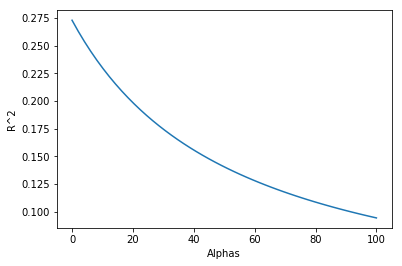

In [107]:
x_train_scaled = preprocessing.scale(x_train)
x_test_scaled = preprocessing.scale(x_test)
y_train_scaled = preprocessing.scale(y_train)
y_test_scaled = preprocessing.scale(y_test)

alphas = np.linspace(0,100,50)
R2 = []

for i in alphas:
    ridge = Ridge(alpha=i)
    ridge.fit(x_train_scaled,y_train_scaled)
    
    y_pred = ridge.predict(x_test_scaled)
    R2.append(r2_score(y_test_scaled, y_pred))

plt.plot(alphas, R2)
plt.xlabel("Alphas")
plt.ylabel("R^2")

**[Solution]:** Based on the plots ablove, $R^2$ does not change very much over different $\alpha$, but when $\alpha = 0$, `Ridge` model has the best performance

**[10 points]** c) What do the coefficients look like for this optimal solution? You can answer this by plotting. Most importantly, do the maginitudes seem roughly comparable?

The best performance happens when alpha = 0.0


E:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Text(0,0.5,'Coef')

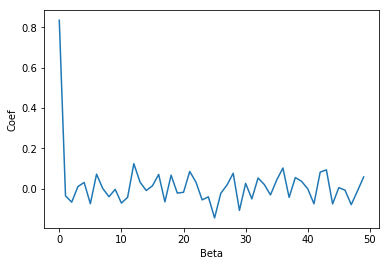

In [108]:
print("The best performance happens when alpha =", alphas[np.argmax(R2)])

ridge = Ridge(alpha=0)
ridge.fit(x_train_scaled,y_train_scaled)
plt.plot(ridge.coef_)
plt.xlabel("Beta")
plt.ylabel("Coef")

**[Solution]:** When $\alpha = 0$, the coefficients are like above plot. It shows that the first feature has high weights, which means first feature is good enough to predict our response. On the other hand, rest of features might contain less information, so the weights are around $0$

## Problem 4: Lasso Reguarlization 

$$ \hat F_{\lambda}(\beta) :=  \|\mathbf{y} - \mathbf{X} \beta\|_{L^2}^2 + \alpha \|\beta\|_{L^1}, $$


a) Now repeat Problem 3 b) using `sklearn`'s `Lasso` method. How does the optimal performance seem to compare to that of `Ridge`? Ensure you are training on training data and evaluating on testing data. 

E:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
E:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


The best performance of Ridge happens when alpha = 0.102, and R^2 is reaching 0.9348096120108524


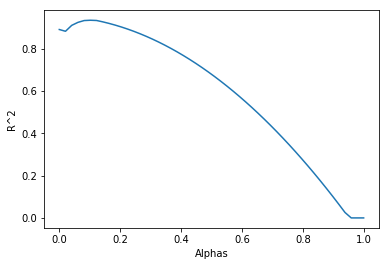

In [109]:
alphas = np.linspace(0,1,50)
R2 = []

for i in alphas:
    lasso = Lasso(alpha=i)
    lasso.fit(x_train_scaled,y_train_scaled)
    
    y_pred = lasso.predict(x_test_scaled)
    R2.append(r2_score(y_test_scaled, y_pred))

plt.plot(alphas, R2)
plt.xlabel("Alphas")
plt.ylabel("R^2")

print("The best performance of Ridge happens when alpha = {0}, and R^2 is reaching {1}".format(round(alphas[np.argmax(R2)],3), max(R2)))

**[Solution]:** When $\alpha = 0.102$, the $R^2$ of `Lasso` is reaching 0.935, which is the best performance, and much better than `Ridge` model.

b) What do the coefficients look like for the optimal $\alpha$ found above? How can you interpret this based on the level sets of $L^1$?

The best performance of Lasso happens when alpha = 0.102, and R^2 is reaching 0.9348096120108524


Text(0,0.5,'Coef')

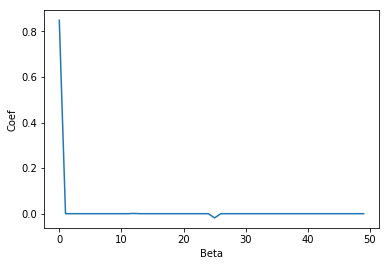

In [110]:
print("The best performance of Lasso happens when alpha = {0}, and R^2 is reaching {1}".format(round(alphas[np.argmax(R2)],3), max(R2)))

lasso = Lasso(alpha=alphas[np.argmax(R2)])
lasso.fit(x_train_scaled,y_train_scaled)
plt.plot(lasso.coef_)
plt.xlabel("Beta")
plt.ylabel("Coef")

**[Solution]:** When $\alpha = 0.102$, the coefficients are like above plot. The coefficient of first variable is $1.32$, but rest of others are $0$. Because of `Lasso` model, most feature variables have been droped out because most the information has been learned from the first feature variable.